In [1]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
tf.config.run_functions_eagerly(True)

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt

# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

# Normalize data frame.
normalized_df = (feature_df - feature_df.mean()) / feature_df.std()

# Perform a train-test split. Looking at the above data, let's train on all data prior to end of year 2005.
# Test on all data from 2005 to end of year 2019
# Keep beginning of 2020 through 2021 seperate for analysis and comparisons with other methods.
dates = np.array(feature_df.index)
# Add 1 to include December as a part of the train.
training_ends = np.where(dates == pd.to_datetime("2009-12-01"))[0][0] + 1
test_ends = np.where(dates == pd.to_datetime("2019-12-01"))[0][0] + 1
X_train, X_test, X_analysis = normalized_df.iloc[:training_ends, :], normalized_df.iloc[training_ends:test_ends, :], normalized_df.iloc[test_ends:, :]
y_train, y_test, y_analysis = response_df['Commodities Market'].iloc[:training_ends], response_df['Commodities Market'].iloc[training_ends:test_ends], response_df['Commodities Market'].iloc[test_ends:]
print(X_train.shape, X_test.shape, X_analysis.shape)

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def graphHistory(history, title):
    """
    Function for graphing the training and valiedation accuracy and loss
    ...
    :param history - history object from keras desired to plot.
    :param title - str that will be the title of the resulting plot.
    """
    # summarize history for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    #axes[0].title('Model Accuracy ' + title)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Tr. Acc', 'Val. Acc'])

    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    #axes[1].title('Model Loss ' + title)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Tr. Loss', 'Val. Loss'])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Do the data transformations...
n_steps = 4
lstm_X_train, lstm_y_train = split_sequence(y_train.values, n_steps)
lstm_X_test, lstm_y_test = split_sequence(y_test.values, n_steps)
dates_test, dates_y_test = split_sequence(dates, n_steps)
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

(216, 58) (120, 58) (19, 58)
(212, 4) (212,) (116, 4) (116,)


## CNN LSTM

Data nees to be transformed to ``(samples, subsequences, timesteps, features)``.

In [2]:
# Reshape from (samples, timesteps) to (samples, subsequnces, timesteps, features)
n_features = 1
n_seq = 2
n_steps = 2
lstm_X_train = lstm_X_train.reshape((lstm_X_train.shape[0], n_seq, n_steps, n_features))
lstm_X_test = lstm_X_test.reshape((lstm_X_test.shape[0], n_seq, n_steps, n_features))
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

(212, 2, 2, 1) (212,) (116, 2, 2, 1) (116,)


2021-09-07 04:20:26.844927: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 25)                9000      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 9,154
Trainable params: 9,154
Non-trainable params: 0
______________________________________________________

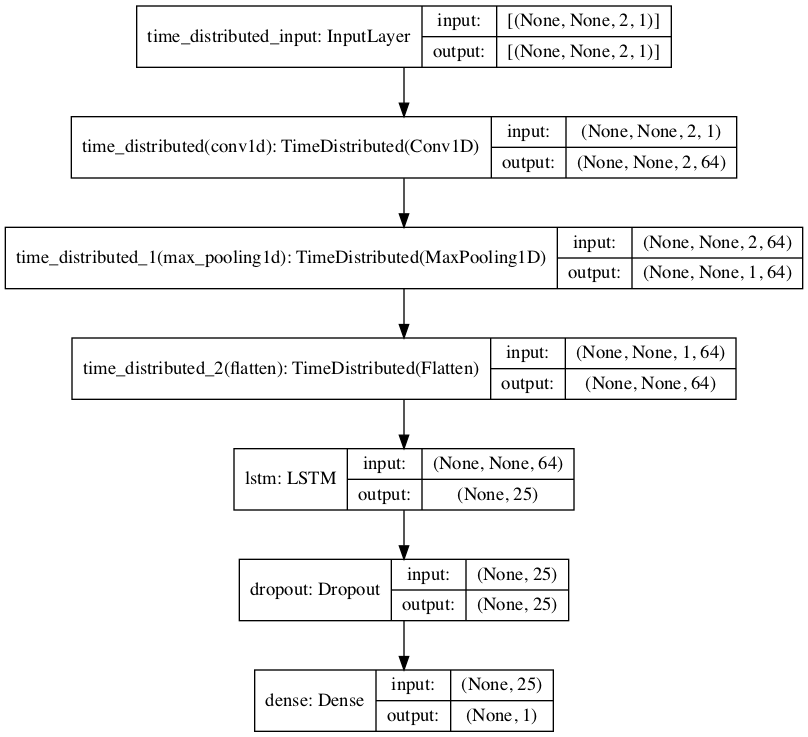

In [3]:
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', kernel_initializer='he_normal'), input_shape=(None, n_steps, n_features)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model.add(tf.keras.layers.LSTM(25, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics='accuracy')
model.summary()
tf.keras.utils.plot_model(model, to_file='cnn-lstm-simple.png', show_shapes=True)

Epoch 1/150
4/7 [================>.............] - ETA: 0s - loss: 20.4252 - accuracy: 0.0078   

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 35ms/step - loss: 34.1796 - accuracy: 0.0094 - val_loss: 23.5053 - val_accuracy: 0.0000e+00
Epoch 2/150
7/7 [==============================] - 0s 24ms/step - loss: 25.5398 - accuracy: 0.0094 - val_loss: 18.3749 - val_accuracy: 0.0000e+00
Epoch 3/150
7/7 [==============================] - 0s 24ms/step - loss: 20.9134 - accuracy: 0.0047 - val_loss: 15.5777 - val_accuracy: 0.0000e+00
Epoch 4/150
7/7 [==============================] - 0s 24ms/step - loss: 16.8260 - accuracy: 0.0094 - val_loss: 14.3165 - val_accuracy: 0.0000e+00
Epoch 5/150
7/7 [==============================] - 0s 24ms/step - loss: 15.0672 - accuracy: 0.0094 - val_loss: 13.7673 - val_accuracy: 0.0000e+00
Epoch 6/150
7/7 [==============================] - 0s 24ms/step - loss: 14.3502 - accuracy: 0.0047 - val_loss: 13.6575 - val_accuracy: 0.0000e+00
Epoch 7/150
7/7 [==============================] - 0s 24ms/step - loss: 14.9953 - accuracy: 0.0047 - val_loss: 13.7538 - val_accuracy: 0

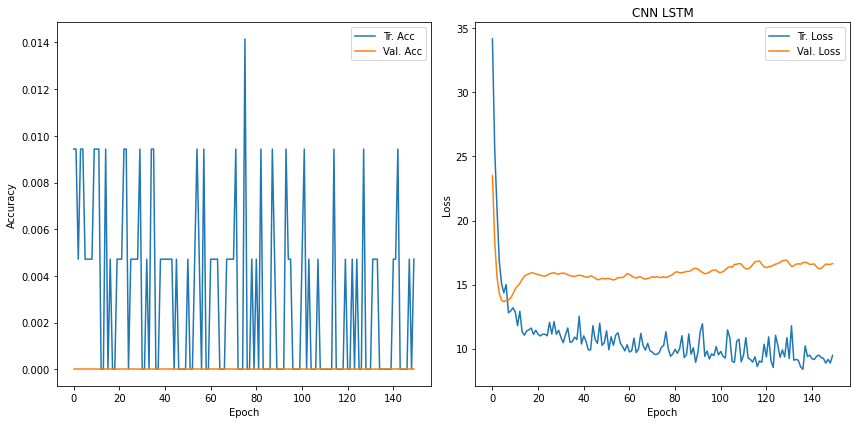

In [55]:
# Train and graph history...
history = model.fit(lstm_X_train, lstm_y_train, epochs=150, validation_data=(lstm_X_test, lstm_y_test), shuffle=False)
graphHistory(history, 'CNN LSTM')

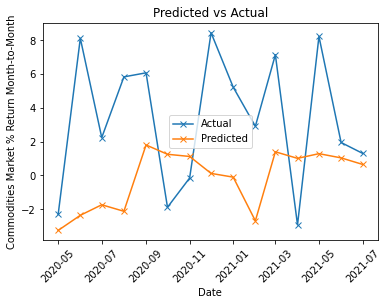

In [56]:
# Predict using the analysis data.
n_steps = 4
analysis_data = y_analysis.values.reshape((y_analysis.shape[0], 1))
lstm_X_analysis, lstm_y_analysis = split_sequence(analysis_data, n_steps)
n_steps = 2
lstm_X_analysis = lstm_X_analysis.reshape((lstm_X_analysis.shape[0], n_seq, n_steps, n_features))

preds = model.predict(lstm_X_analysis)
np.linalg.norm(preds - lstm_y_analysis.reshape(preds.shape[0], 1))

# Plot all test data and then validation data and prediction data...
dates_test, dates_y_test = split_sequence(dates[training_ends: test_ends], 4)
dates_val, dates_y_val = split_sequence(dates[test_ends:], 4)
dates_test.shape, dates_val.shape, dates_y_test.shape, dates_y_val.shape
actual_dates = np.hstack((dates_y_test, dates_y_val))
pred_vals = preds.reshape(preds.shape[0], )
pred_dates = dates_y_val
plt.plot(pred_dates, lstm_y_analysis, label='Actual', marker='x')
plt.plot(pred_dates, pred_vals, label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Commodities Market % Return Month-to-Month')
plt.title('Predicted vs Actual')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [40]:
lstm_X_analysis.shape

(15, 2, 2, 1)

In [4]:
##########################
# Multi-variate CNN LSTM #
##########################
# define a fx. to split a multivariate sequence into samples
def split_sequences_mv(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [5]:
# Concat the X_train and y_train
dataset = np.hstack((X_train.values, y_train.values.reshape((y_train.shape[0], 1))))
test_data = np.hstack((X_test.values, y_test.values.reshape((y_test.shape[0], 1))))
X_train.shape, y_train.shape, dataset.shape, type(dataset)

((216, 58), (216,), (216, 59), numpy.ndarray)

In [6]:
# Do the data transformations...
n_steps = 4
lstm_X_train, lstm_y_train = split_sequences_mv(dataset, n_steps)
lstm_X_test, lstm_y_test = split_sequences_mv(test_data, n_steps)
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

# Reshape from (samples, timesteps) to (samples, subsequnces, timesteps, features)
n_features = 58
n_seq = 2
n_steps = 2
lstm_X_train = lstm_X_train.reshape((lstm_X_train.shape[0], n_seq, n_steps, n_features))
lstm_X_test = lstm_X_test.reshape((lstm_X_test.shape[0], n_seq, n_steps, n_features))
print(lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape)

(213, 4, 58) (213,) (117, 4, 58) (117,)
(213, 2, 2, 58) (213,) (117, 2, 2, 58) (117,)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 2, 32)       1888      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 1, 32)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 9,479
Trainable params: 9,479
Non-trainable params: 0
____________________________________________________

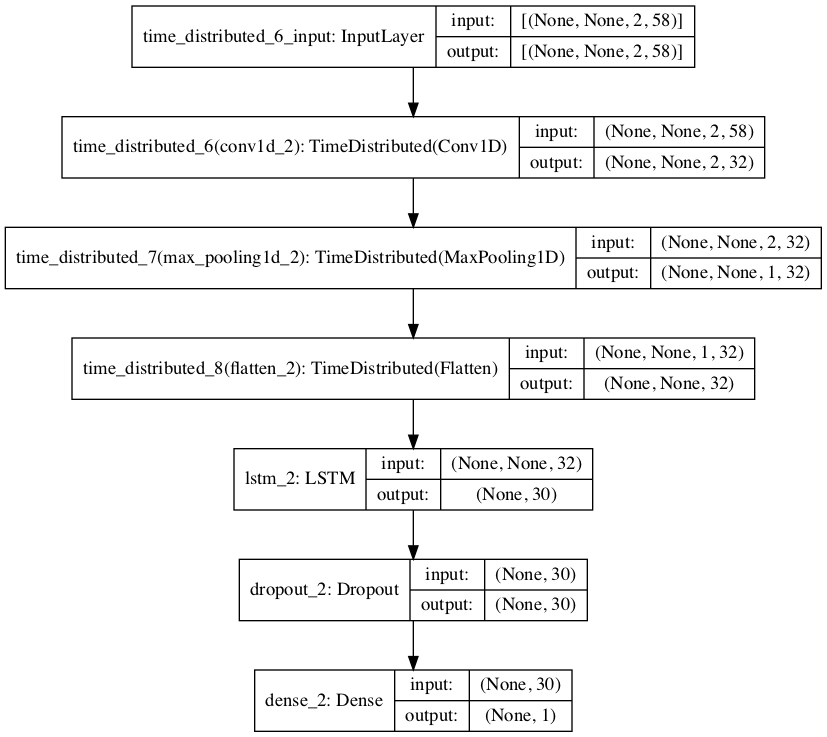

In [8]:
# Define the model.
n_features = lstm_X_train.shape[3]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=32, kernel_size=1, kernel_initializer='he_normal', activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model.add(tf.keras.layers.LSTM(30, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics='accuracy')
model.summary()
tf.keras.utils.plot_model(model, to_file='cnn-lstm-multi.png', show_shapes=True)

Epoch 1/150
7/7 [==============================] - ETA: 0s - loss: 3.0980 - accuracy: 0.0094

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 29ms/step - loss: 3.0980 - accuracy: 0.0094 - val_loss: 1.7060 - val_accuracy: 0.0000e+00
Epoch 2/150
7/7 [==============================] - 0s 25ms/step - loss: 2.3526 - accuracy: 0.0094 - val_loss: 1.7343 - val_accuracy: 0.0000e+00
Epoch 3/150
7/7 [==============================] - 0s 25ms/step - loss: 2.0071 - accuracy: 0.0094 - val_loss: 1.7670 - val_accuracy: 0.0000e+00
Epoch 4/150
7/7 [==============================] - 0s 25ms/step - loss: 2.0445 - accuracy: 0.0141 - val_loss: 1.7792 - val_accuracy: 0.0000e+00
Epoch 5/150
7/7 [==============================] - 0s 29ms/step - loss: 1.9622 - accuracy: 0.0094 - val_loss: 1.7845 - val_accuracy: 0.0000e+00
Epoch 6/150
7/7 [==============================] - 0s 31ms/step - loss: 1.9178 - accuracy: 0.0094 - val_loss: 1.7900 - val_accuracy: 0.0000e+00
Epoch 7/150
7/7 [==============================] - 0s 26ms/step - loss: 1.8113 - accuracy: 0.0094 - val_loss: 1.7762 - val_accuracy: 0.0000e+00
Epoc

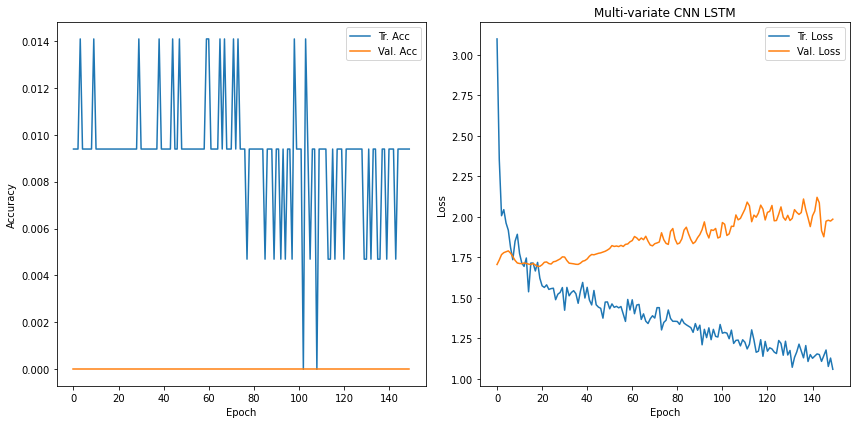

In [45]:
# Train and graph history...
history = model.fit(lstm_X_train, lstm_y_train, epochs=150, validation_data=(lstm_X_test, lstm_y_test), shuffle=False)
graphHistory(history, 'Multi-variate CNN LSTM')

In [46]:
# Predict using the analysis data.
n_steps = 4
analysis_data = np.hstack((X_analysis.values, y_analysis.values.reshape((y_analysis.shape[0], 1))))
lstm_X_analysis, lstm_y_analysis = split_sequences_mv(analysis_data, n_steps)
n_steps = 2
lstm_X_analysis = lstm_X_analysis.reshape((lstm_X_analysis.shape[0], n_seq, n_steps, n_features))

preds = model.predict(lstm_X_analysis)
np.linalg.norm(preds - lstm_y_analysis.reshape(preds.shape[0], 1))

7.781250153058189

In [47]:
dates_test, dates_y_test = split_sequence(dates[training_ends: test_ends], 4)
dates_val, dates_y_val = split_sequence(dates[test_ends:], 4)
dates_test.shape, dates_val.shape, dates_y_test.shape, dates_y_val.shape

((116, 4), (15, 4), (116,), (15,))

In [51]:
# Plot all test data and then validation data and prediction data...
# Plot all test data and then validation data and prediction data...

# Predict using the analysis data.
n_features=58
n_steps = 4
analysis_data = y_analysis.values.reshape((y_analysis.shape[0], 1))
lstm_X_analysis, lstm_y_analysis = split_sequence(analysis_data, n_steps)
n_steps = 2
lstm_X_analysis = lstm_X_analysis.reshape((lstm_X_analysis.shape[0], n_seq, n_steps, n_features))

preds = model.predict(lstm_X_analysis)
dates_test, dates_y_test = split_sequence(dates[training_ends: test_ends], 4)
dates_val, dates_y_val = split_sequence(dates[test_ends:], 4)
dates_test.shape, dates_val.shape, dates_y_test.shape, dates_y_val.shape
actual_dates = np.hstack((dates_y_test, dates_y_val))
pred_vals = preds.reshape(preds.shape[0], )
pred_dates = dates_y_val
plt.plot(pred_dates, lstm_y_analysis, label='Actual', marker='x')
plt.plot(pred_dates, pred_vals, label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Fixed Income % Return Month-to-Month')
plt.title('Predicted vs Actual')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

ValueError: cannot reshape array of size 60 into shape (15,2,2,58)

In [28]:
lstm_y_test.shape, lstm_y_analysis.shape

((117,), (15, 1))